In [28]:
import pandas as pd
import tensorflow_text as text
import tensorflow_hub as hup 
import tensorflow as tf

In [2]:
dataset = pd.read_csv('SPAM.csv')
dataset.head(5)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
dataset.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [4]:
dataset['Category'].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

In [8]:
spam_shape= dataset[dataset['Category']=='spam'].shape
ham_shape= dataset[dataset['Category']=='ham'].shape

In [9]:
spam_dataset= dataset[dataset['Category']=='spam']
spam_dataset.shape

(747, 2)

In [10]:
ham_dataset= dataset[dataset['Category']=='ham']
ham_dataset.shape

(4825, 2)

In [12]:
ham_dataset =ham_dataset.sample(spam_shape[0])
ham_dataset.shape

(747, 2)

In [18]:
balanced_dataset = pd.concat([spam_dataset,ham_dataset])
balanced_dataset.sample(5)

,Category,Message
2821,spam,INTERFLORA - It's not too late to order Inter...
1839,spam,Hack Chat. Get backdoor entry into 121 chat ro...
3863,ham,"Customer place, i wil cal u sir."
2816,ham,Some are lasting as much as 2 hours. You might...
1881,ham,Just seeing your missed call my dear brother. ...


In [19]:
balanced_dataset['Category'].value_counts()

spam    747
ham     747
Name: Category, dtype: int64

In [20]:
balanced_dataset['Spam']=balanced_dataset['Category'].apply(lambda x:1 if x=='spam' else 0)
balanced_dataset.sample(6)

,Category,Message,Spam
1217,spam,You have 1 new voicemail. Please call 08719181...,1
357,spam,Congratulations ur awarded 500 of CD vouchers ...,1
4954,ham,I lost 4 pounds since my doc visit last week w...,0
4890,ham,"Japanese Proverb: If one Can do it, U too Can ...",0
2681,ham,Solve d Case : A Man Was Found Murdered On &l...,0
4557,ham,Gettin rdy to ship comp,0


In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(balanced_dataset['Message'], balanced_dataset['Spam'] ,stratify=balanced_dataset['Spam'])

In [25]:
len(X_train) , len(X_test)

(1120, 374)

In [26]:
bert_preprocess = hup.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder    = hup.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4") 

In [29]:
# Bert layers (functional model)
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [30]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [31]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [32]:
model.fit(X_train, y_train, epochs=10)


Epoch 1/10
35/35 [==============================] - 17s 259ms/step - loss: 0.6340 - accuracy: 0.6473 - precision: 0.6514 - recall: 0.6339
Epoch 2/10
35/35 [==============================] - 9s 253ms/step - loss: 0.5093 - accuracy: 0.8223 - precision: 0.8085 - recall: 0.8446
Epoch 3/10
35/35 [==============================] - 9s 257ms/step - loss: 0.4561 - accuracy: 0.8411 - precision: 0.8205 - recall: 0.8732
Epoch 4/10
35/35 [==============================] - 9s 263ms/step - loss: 0.4012 - accuracy: 0.8777 - precision: 0.8640 - recall: 0.8964
Epoch 5/10
35/35 [==============================] - 9s 257ms/step - loss: 0.3710 - accuracy: 0.8911 - precision: 0.8789 - recall: 0.9071
Epoch 6/10
35/35 [==============================] - 9s 253ms/step - loss: 0.3474 - accuracy: 0.8875 - precision: 0.8780 - recall: 0.9000
Epoch 7/10
35/35 [==============================] - 9s 258ms/step - loss: 0.3276 - accuracy: 0.9018 - precision: 0.8947 - recall: 0.9107
Epoch 8/10
35/35 [======================

In [33]:
model.evaluate(X_test,y_test)

12/12 [==============================] - 4s 243ms/step - loss: 0.2607 - accuracy: 0.9171 - precision: 0.9062 - recall: 0.9305


[0.2606629431247711, 0.9171122908592224, 0.90625, 0.9304812550544739]

In [40]:
y_predicted = model.predict(X_test)

In [37]:
type(y_predicted)

numpy.ndarray

In [42]:
y_predicted = y_predicted.flatten()
type(y_predicted)

numpy.ndarray

In [43]:
import numpy as np

y_predicted=np.where(y_predicted>0.5 ,1,0)
y_predicted

array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1,

In [44]:
from sklearn.metrics import confusion_matrix , classification_report
matrix = confusion_matrix(y_test, y_predicted)
matrix

array([[169,  18],
       [ 13, 174]], dtype=int64)

Text(33.0, 0.5, 'truth')

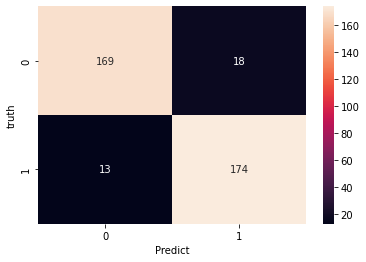

In [50]:
import matplotlib.pyplot as plt
import seaborn as sn
sn.heatmap(matrix,annot=True , fmt='d')
plt.xlabel("Predict")
plt.ylabel("truth")

In [51]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)

array([[0.71799135],
       [0.8442797 ],
       [0.78906673],
       [0.17219822],
       [0.09650222]], dtype=float32)